<a href="https://colab.research.google.com/github/yen010390/Classify-the-topic-of-an-article/blob/main/Project_3_1_Classify_the_topic_of_an_article.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**1. Thư viện**

In [21]:
import os, re, json, random, warnings
from typing import List, Optional, Tuple, Dict
from collections import Counter
from pathlib import Path
import gc

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datasets import load_dataset
from sentence_transformers import SentenceTransformer

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score, f1_score, classification_report, confusion_matrix, make_scorer
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import LinearSVC
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# imbalanced-learn
try:
    from imblearn.over_sampling import SMOTE, RandomOverSampler
    from imblearn.under_sampling import RandomUnderSampler
    _IMB_OK = True
except Exception:
    _IMB_OK = False
    warnings.warn("imbalanced-learn chưa cài; SMOTE/ROS/RUS sẽ bị tắt. pip install imbalanced-learn")

warnings.filterwarnings("ignore")
sns.set_style("whitegrid")

SEED = 42
RANDOM_STATE = 42
CACHE_DIR = "./cache"

In [2]:
#Tạo block cấu hình đường dẫn/ Figure/Report paths
from types import SimpleNamespace
FIG_ROOT = os.path.join("pdf", "Figures")
PATHS = SimpleNamespace(
    root=FIG_ROOT,
    balanced=os.path.join(FIG_ROOT, "balanced"),
    all_models=os.path.join(FIG_ROOT, "all_models"),
)
for d in (PATHS.root, PATHS.balanced, PATHS.all_models):
    os.makedirs(d, exist_ok=True)

#**2. Xử lý dữ liệu**

In [3]:
# ========================== DATA LOADING & CLEANING ==========================
def load_arxiv_subset(cache_dir=CACHE_DIR,
                      categories=('astro-ph','cond-mat','cs','math','physics'),
                      max_samples=1000) -> Tuple[List[str], List[str]]:
    ds = load_dataset("UniverseTBD/arxiv-abstracts-large", cache_dir=cache_dir)
    keep = []
    for s in ds['train']:
        # chỉ giữ 1 nhãn và thuộc categories mong muốn
        if len(s['categories'].split(' ')) != 1:
            continue
        cat = s['categories'].split(' ')[0].split('.')[0]
        if cat in categories:
            keep.append((s['abstract'], cat))
            if len(keep) >= max_samples:
                break
    texts, labels = zip(*keep)
    return list(texts), list(labels)

def clean_text(s: str) -> str:
    s = s.strip().replace("\n", " ")
    s = re.sub(r'[^\w\s]', ' ', s)
    s = re.sub(r'\d+', ' ', s)
    s = re.sub(r'\s+', ' ', s).strip()
    return s.lower()

def prepare_dataset(cache_dir=CACHE_DIR, cats=('astro-ph','cond-mat','cs','math','physics'),
                    max_samples=1000, seed=SEED):
    X_texts, y_labels = load_arxiv_subset(cache_dir, cats, max_samples)
    X_texts = [clean_text(t) for t in X_texts]
    labels_sorted = sorted(set(y_labels))
    label2id = {l:i for i,l in enumerate(labels_sorted)}
    y_ids = [label2id[l] for l in y_labels]
    X_train, X_test, y_train, y_test = train_test_split(
        X_texts, y_ids, test_size=0.2, random_state=seed, stratify=y_ids
    )
    return (X_train, X_test, y_train, y_test, labels_sorted, label2id)

# **3. AUGMENT + BALANCE**

In [4]:
# WordNet augment (đơn giản) + cân bằng theo lớp
try:
    import nltk
    nltk.data.find('corpora/wordnet')
except Exception:
    try:
        import nltk
        nltk.download('wordnet', quiet=True)
        nltk.download('omw-1.4', quiet=True)
    except Exception:
        pass
try:
    from nltk.corpus import wordnet as wn
    _WORDNET_OK = True
except Exception:
    _WORDNET_OK = False

def _tokenize_simple(s: str) -> List[str]: return s.split()

def _rand_del(tokens: List[str], p: float) -> List[str]:
    if not tokens: return tokens
    out = [t for t in tokens if random.random() > p]
    return out if out else tokens

def _rand_swap(tokens: List[str], n: int) -> List[str]:
    if len(tokens) < 2 or n <= 0: return tokens
    tokens = tokens.copy()
    for _ in range(n):
        i, j = random.sample(range(len(tokens)), 2)
        tokens[i], tokens[j] = tokens[j], tokens[i]
    return tokens

def _syns(w: str) -> List[str]:
    if not _WORDNET_OK or not w.isalpha(): return []
    syn = set()
    for synset in wn.synsets(w):
        for lem in synset.lemmas():
            ww = lem.name().replace('_',' ').lower()
            if ww != w: syn.add(ww)
    return list(syn)

def _syn_replace(tokens: List[str], ratio: float) -> List[str]:
    if not _WORDNET_OK or ratio <= 0 or not tokens: return tokens
    tokens = tokens.copy()
    need = max(1, int(len(tokens)*ratio))
    idx = list(range(len(tokens))); random.shuffle(idx)
    ch = 0
    for i in idx:
        cands = _syns(tokens[i])
        if cands:
            tokens[i] = random.choice(cands); ch += 1
        if ch >= need: break
    return tokens

def eda(text: str, p_del=0.10, p_swap=0.10, p_syn=0.10, num_aug=1) -> List[str]:
    out = []
    base = _tokenize_simple(text)
    for _ in range(num_aug):
        t = _rand_del(base, p_del)
        t = _rand_swap(t, max(1, int(len(t)*p_swap)) if len(t)>1 else 0)
        t = _syn_replace(t, p_syn)
        out.append(' '.join(t))
    return out

def augment_and_balance(X: List[str], y: List[int], target_per_class=300, seed=SEED):
    random.seed(seed)
    cnt = Counter(y)
    classes = sorted(cnt.keys())
    cur_max = max(cnt.values()) if cnt else 0
    target = max(min(target_per_class, max(cur_max,1)), 1)
    by_cls = {c:[x for x,yy in zip(X,y) if yy==c] for c in classes}
    X_aug, y_aug = [], []
    for c in classes:
        need = max(0, target - len(by_cls[c]))
        i = 0
        while need > 0 and by_cls[c]:
            base = by_cls[c][i % len(by_cls[c])]
            for a in eda(base):
                X_aug.append(a); y_aug.append(c)
                need -= 1
                if need<=0: break
            i += 1
    X2 = X + X_aug; y2 = y + y_aug
    print("🔧 Augmented per-class counts:", dict(sorted(Counter(y2).items())))
    print(f"🔼 Train size: {len(X)} → {len(X2)} (+{len(X_aug)})")
    return X2, y2

# **4. VECTORIZERS / EMBEDDINGS**

In [5]:
class EmbeddingVectorizer:
    def __init__(self, model_name="intfloat/multilingual-e5-base", normalize=True, device=None):
        self.model = SentenceTransformer(model_name, device=device)
        self.normalize = normalize
    def _fmt(self, texts: List[str], mode="query"):
        if mode == "raw": return texts
        if mode not in {"query","passage"}:
            raise ValueError("mode phải là 'query' | 'passage' | 'raw'")
        return [f"{mode}: {t.strip()}" for t in texts]
    def transform_numpy(self, texts: List[str], mode="query") -> np.ndarray:
        embs = self.model.encode(self._fmt(texts, mode),
                                 normalize_embeddings=self.normalize,
                                 convert_to_numpy=True, batch_size=64, show_progress_bar=False)
        return embs

# **5. BALANCING HELPER**

In [6]:
def _fallback_over(X, y):
    y = np.asarray(y); classes, counts = np.unique(y, return_counts=True)
    m = counts.max()
    idx_all = np.arange(len(y))
    idx_new = np.concatenate([
        np.tile(idx_all[y==c], int(np.ceil(m/(y==c).sum())))[:m] for c in classes
    ])
    if hasattr(X, "shape") or hasattr(X, "toarray"): X_new = X[idx_new]
    else: X_new = [X[i] for i in idx_new]
    return X_new, y[idx_new]

def _fallback_under(X, y):
    y = np.asarray(y); classes, counts = np.unique(y, return_counts=True)
    m = counts.min()
    rng = np.random.default_rng(SEED)
    idx_new = np.concatenate([ rng.choice(np.where(y==c)[0], size=m, replace=False) for c in classes ])
    rng.shuffle(idx_new)
    if hasattr(X, "shape") or hasattr(X, "toarray"): X_new = X[idx_new]
    else: X_new = [X[i] for i in idx_new]
    return X_new, y[idx_new]

def make_balanced(X, y, strategy="none", for_embeddings=False):
    """
    strategy: 'none' | 'over' | 'under' | 'smote' (SMOTE chỉ cho embeddings dense + imblearn)
    """
    if strategy == "none": return X, y
    is_sparse = hasattr(X, "toarray")
    if strategy == "smote":
        if not for_embeddings or is_sparse or not _IMB_OK:
            print("⚠️ SMOTE không áp dụng → fallback 'over'.")
            strategy = "over"
    if strategy in {"over","under"} and not _IMB_OK:
        return _fallback_over(X,y) if strategy=="over" else _fallback_under(X,y)
    if strategy in {"over","under"} and _IMB_OK:
        sampler = RandomOverSampler(random_state=SEED) if strategy=="over" \
                  else RandomUnderSampler(random_state=SEED)
        Xb, yb = sampler.fit_resample(X, np.asarray(y)); return Xb, yb
    if strategy == "smote":
        Xb, yb = SMOTE(random_state=SEED, k_neighbors=5).fit_resample(X, np.asarray(y))
        return Xb, yb
    return X, y

# **5. Huấn luyện - PLOTS HELPERS**


In [7]:
# ========================== EVAL / PLOTS HELPERS ==========================
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
f1_scorer = make_scorer(f1_score, average="macro")

def to_dense(X):
    return X.toarray() if hasattr(X, "toarray") else X

def plot_curve(xs, ys, xlabel, title, semilog=False):
    plt.figure(figsize=(6.4,4.2))
    (plt.semilogx if semilog else plt.plot)(xs, ys, marker='o')
    plt.xlabel(xlabel); plt.ylabel('Mean CV F1 (macro)')
    plt.title(title); plt.grid(True, alpha=.35); plt.tight_layout(); plt.show()

def cm_with_percent(cm: np.ndarray) -> np.ndarray:
    cmn = cm.astype(float) / np.clip(cm.sum(axis=1, keepdims=True), 1, None)
    ann = np.empty_like(cm).astype(str)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ann[i, j] = f"{cm[i,j]}\n({cmn[i,j]:.2%})"
    return ann

def save_confusion(y_true, y_pred, class_names, title, save_dir, fname_stub, show=True):
    labels_idx = list(range(len(class_names)))
    cm = confusion_matrix(y_true, y_pred, labels=labels_idx)
    ann = cm_with_percent(cm)
    plt.figure(figsize=(6.8,5.2))
    sns.heatmap(cm, annot=ann, fmt="", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names,
                cbar=False, linewidths=1, linecolor='black')
    plt.xlabel("Predicted"); plt.ylabel("True"); plt.title(title)
    plt.tight_layout()
    fn = re.sub(r"[^a-zA-Z0-9\-_.]+", "_", fname_stub) + "_cm.pdf"
    path = os.path.join(save_dir, fn)
    plt.savefig(path, bbox_inches="tight")
    if show: plt.show()
    else: plt.close()

def summarize_result(name, y_true, y_pred) -> Dict[str, float]:
    return dict(
        model_feature=name,
        accuracy=accuracy_score(y_true, y_pred),
        f1_macro=f1_score(y_true, y_pred, average="macro"),
        f1_weighted=f1_score(y_true, y_pred, average="weighted"),
    )

# **6. MODEL TUNERS**

In [13]:
def tune_knn(X, y, title, ks=range(3,31,2)):
    scores = []
    for k in ks:
        clf = KNeighborsClassifier(n_neighbors=k, metric="cosine", algorithm="brute")
        scores.append(cross_val_score(clf, X, y, cv=cv, scoring=f1_scorer, n_jobs=-1).mean())
    plot_curve(list(ks), scores, "k", title)
    k_star = int(list(ks)[int(np.argmax(scores))])
    return k_star

def tune_dt(X, y, title, depth_range=range(1,21)):
    scores = []
    for d in depth_range:
        clf = DecisionTreeClassifier(max_depth=d, class_weight="balanced", random_state=SEED)
        scores.append(cross_val_score(clf, X, y, cv=cv, scoring=f1_scorer, n_jobs=-1).mean())
    plot_curve(list(depth_range), scores, "max_depth", title)
    return int(list(depth_range)[int(np.argmax(scores))])

def tune_mnb(X, y, title, alphas=np.logspace(-3,1,9)):
    means = []
    for a in alphas:
        means.append(cross_val_score(MultinomialNB(alpha=a), X, y, cv=cv, scoring=f1_scorer, n_jobs=-1).mean())
    plot_curve(alphas, means, "alpha (log)", title, semilog=True)
    return float(alphas[int(np.argmax(means))])

def tune_gnb(X, y, title, var_spaces=np.logspace(-12,-6,13)):
    means = []
    for v in var_spaces:
        means.append(cross_val_score(GaussianNB(var_smoothing=v), X, y, cv=cv, scoring=f1_scorer, n_jobs=-1).mean())
    plot_curve(var_spaces, means, "var_smoothing (log)", title, semilog=True)
    return float(var_spaces[int(np.argmax(means))])

def tune_ridge(X, y, title, alphas=np.logspace(-3,2,10)):
    means = []
    for a in alphas:
        clf = RidgeClassifier(alpha=a, class_weight='balanced', random_state=SEED)
        means.append(cross_val_score(clf, X, y, cv=cv, scoring=f1_scorer, n_jobs=-1).mean())
    plot_curve(alphas, means, "alpha (log)", title, semilog=True)
    return float(alphas[int(np.argmax(means))])

def tune_logreg(X, y, title, Cs=np.logspace(-3,2,10)):
    means = []
    for C in Cs:
        clf = LogisticRegression(C=C, penalty='l2', solver='saga', max_iter=3000,
                                 class_weight='balanced', random_state=SEED, n_jobs=-1)
        means.append(cross_val_score(clf, X, y, cv=cv, scoring=f1_scorer, n_jobs=-1).mean())
    plot_curve(Cs, means, "C (log)", title, semilog=True)
    return float(Cs[int(np.argmax(means))])

def tune_linsvc(X, y, title, Cs=np.logspace(-3,2,10)):
    means = []
    for C in Cs:
        clf = LinearSVC(C=C, class_weight='balanced', random_state=SEED)
        means.append(cross_val_score(clf, X, y, cv=cv, scoring=f1_scorer, n_jobs=-1).mean())
    plot_curve(Cs, means, "C (log)", title, semilog=True)
    return float(Cs[int(np.argmax(means))])

# **7. Huấn luyện - MAIN PIPELINE**

In [8]:
# ========================== MAIN PIPELINE ==========================
# 1) Chuẩn bị dữ liệu
X_train, X_test, y_train, y_test, class_names, label2id = prepare_dataset()

# 2) Augment + balance (bật/tắt bằng flag)
AUGMENT = True
if AUGMENT:
    X_train, y_train = augment_and_balance(X_train, y_train, target_per_class=300, seed=SEED)

# 3) Vector hoá
bow_vec   = CountVectorizer(min_df=2)
tfidf_vec = TfidfVectorizer(min_df=2, ngram_range=(1,2))
X_train_bow  = bow_vec.fit_transform(X_train);   X_test_bow  = bow_vec.transform(X_test)
X_train_tfidf= tfidf_vec.fit_transform(X_train); X_test_tfidf= tfidf_vec.transform(X_test)

emb_vec = EmbeddingVectorizer()
X_train_emb = emb_vec.transform_numpy(X_train)  # (N,768)
X_test_emb  = emb_vec.transform_numpy(X_test)

🔧 Augmented per-class counts: {0: 347, 1: 300, 2: 300, 3: 300, 4: 300}
🔼 Train size: 800 → 1547 (+747)


In [9]:
# 4) Cân bằng theo đặc trưng
BALANCE_BOW = "over"     # 'none'|'over'|'under'
BALANCE_TFIDF = "over"
BALANCE_EMB = "smote"    # 'smote' tốt cho dense embeddings

X_train_bow_bal,   y_train_bow_bal   = make_balanced(X_train_bow,   y_train, BALANCE_BOW,   for_embeddings=False)
X_train_tfidf_bal, y_train_tfidf_bal = make_balanced(X_train_tfidf, y_train, BALANCE_TFIDF, for_embeddings=False)
X_train_emb_bal,   y_train_emb_bal   = make_balanced(X_train_emb,   y_train, BALANCE_EMB,   for_embeddings=True)

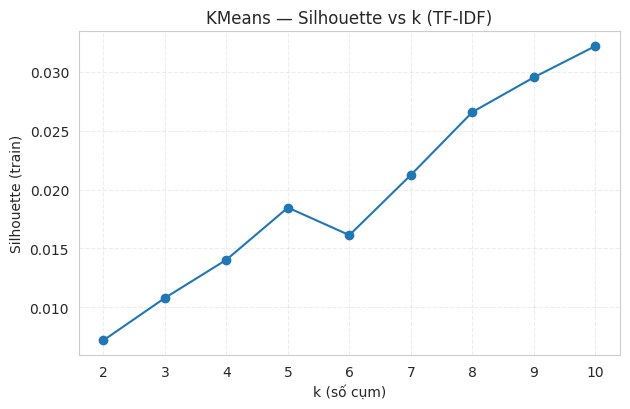

✅ KMeans — best k: 10 | Silhouette=0.0322


In [10]:
# 5) KMeans (trên TF-IDF) — silhouette vs k
k_candidates = range(2, 11)
sil_scores = []
for k in k_candidates:
    km = KMeans(n_clusters=k, n_init=10, random_state=SEED)
    lab_tr = km.fit_predict(X_train_tfidf)
    sil_scores.append(silhouette_score(X_train_tfidf, lab_tr))
plt.figure(figsize=(6.4,4.2))
plt.plot(list(k_candidates), sil_scores, marker='o')
plt.xlabel("k (số cụm)"); plt.ylabel("Silhouette (train)")
plt.title("KMeans — Silhouette vs k (TF-IDF)"); plt.grid(True, ls="--", alpha=.35)
plt.tight_layout(); plt.show()
best_k_kmeans = int(list(k_candidates)[int(np.argmax(sil_scores))])
print(f"✅ KMeans — best k: {best_k_kmeans} | Silhouette={np.max(sil_scores):.4f}")

def _cluster_majority_mapping(labels_train, y_train):
    y_train = np.asarray(y_train); mapping={}
    for cid in np.unique(labels_train):
        mask = (labels_train==cid)
        base = y_train[mask] if np.any(mask) else y_train
        mapping[cid] = Counter(base).most_common(1)[0][0]
    return mapping

km_best = KMeans(n_clusters=best_k_kmeans, n_init=10, random_state=SEED).fit(X_train_tfidf)
km_map = _cluster_majority_mapping(km_best.labels_, y_train)
kmeans_pred = np.array([km_map[c] for c in km_best.predict(X_test_tfidf)])

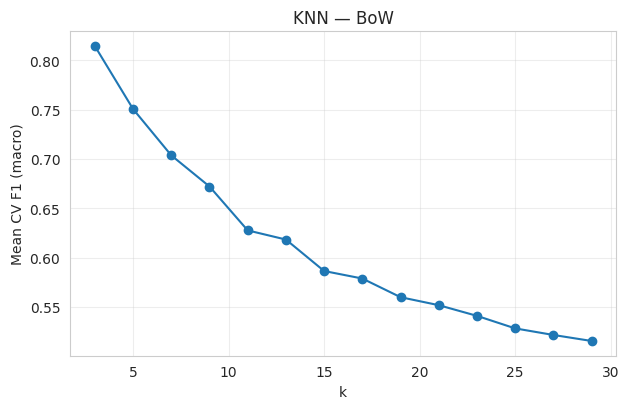

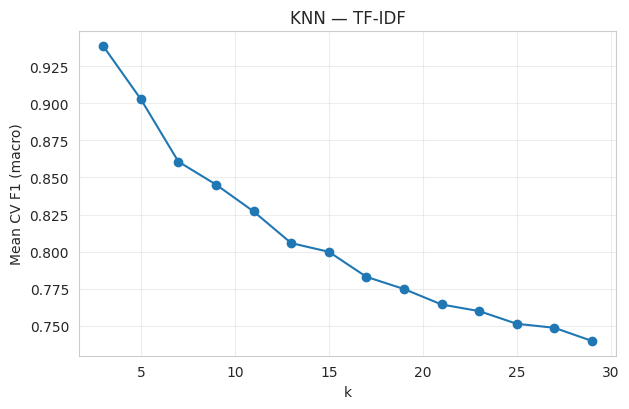

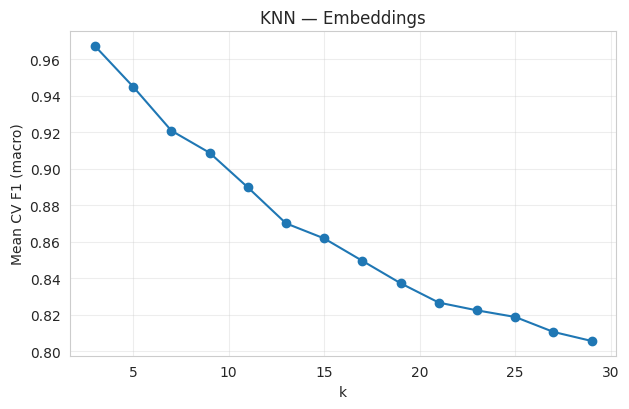

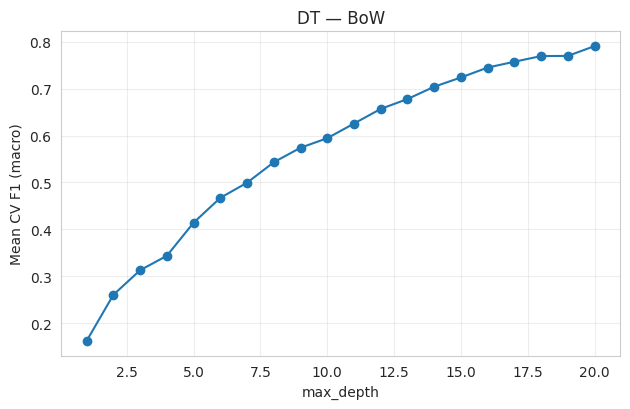

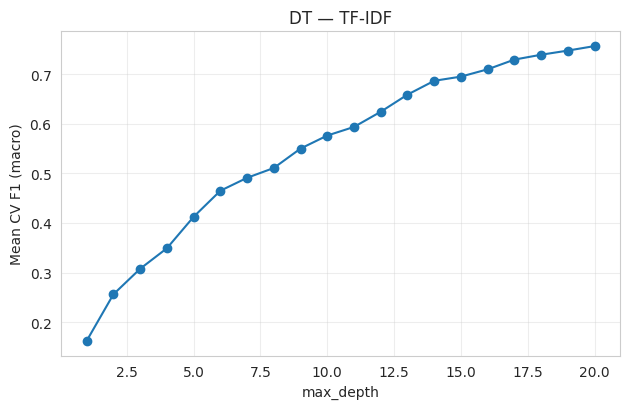

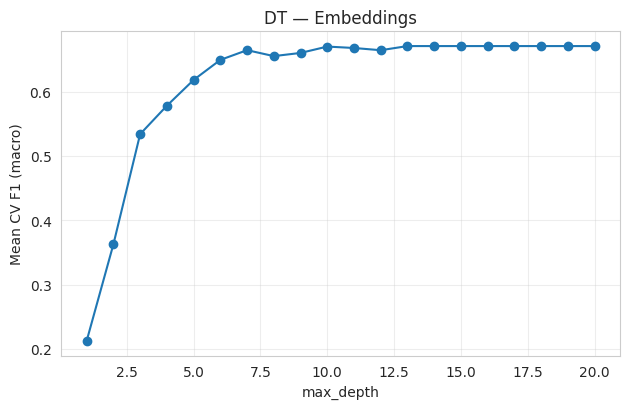

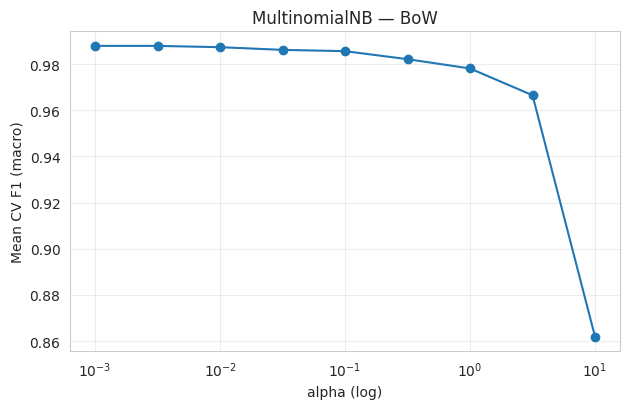

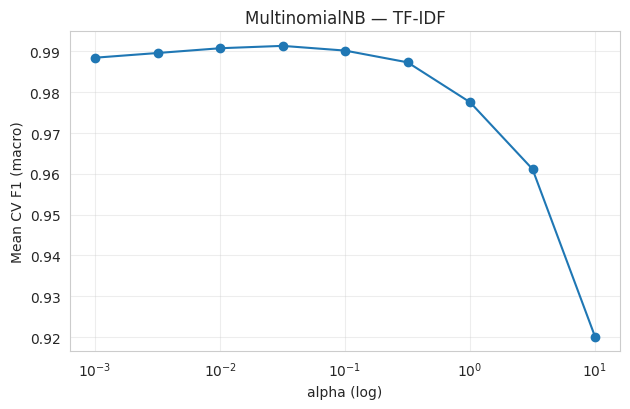

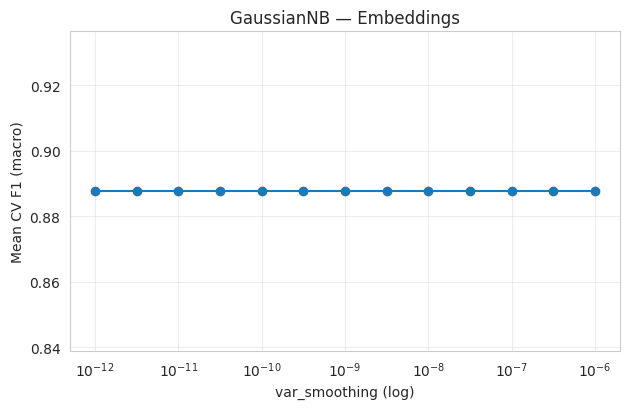

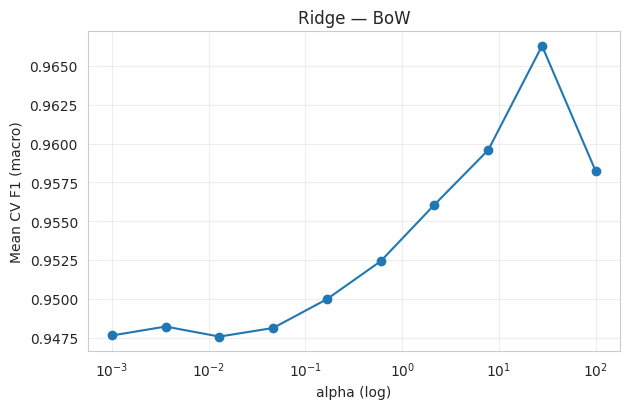

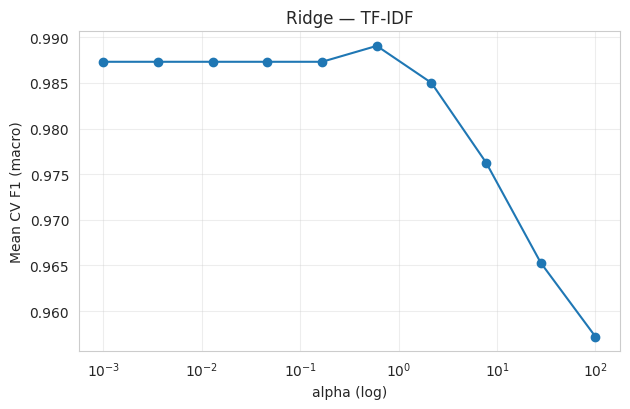

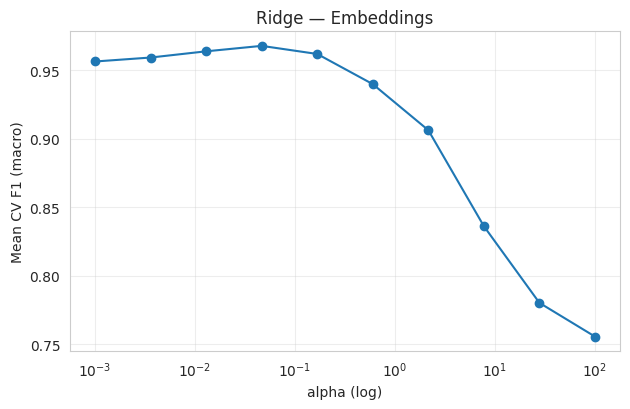

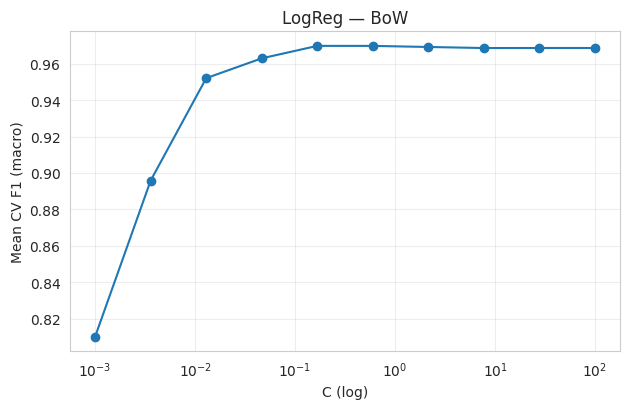

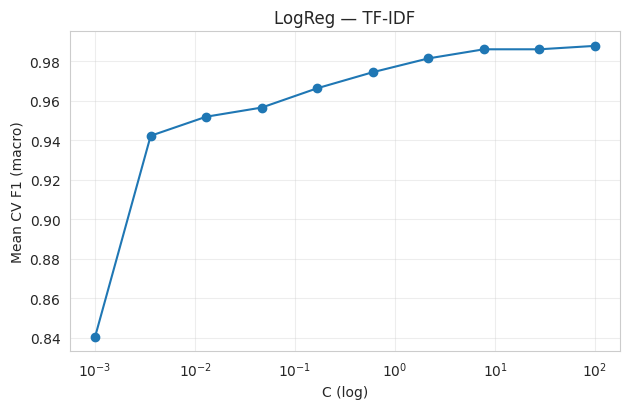

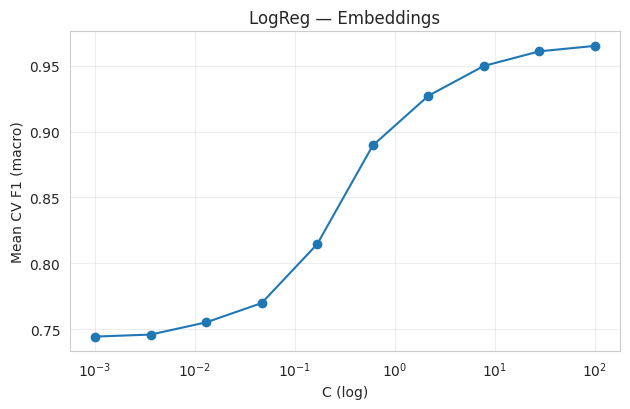

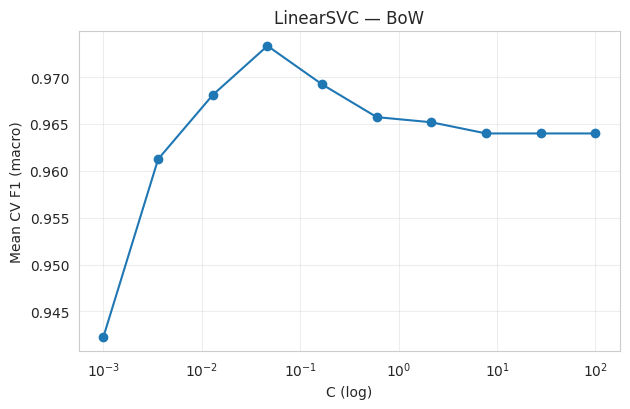

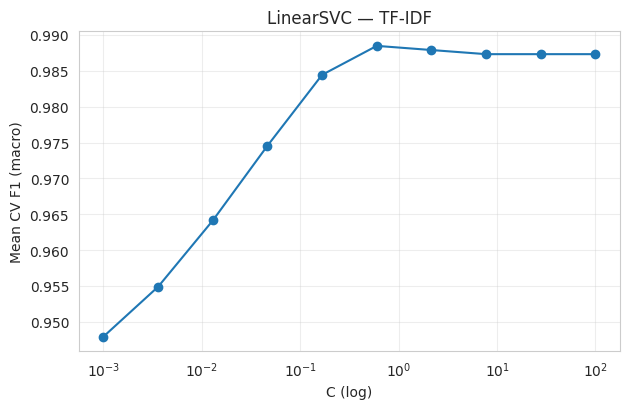

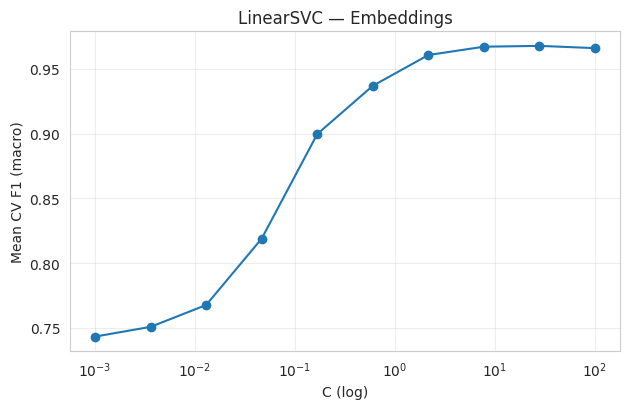

In [14]:
# 6) Tuning + Train từng họ mô hình
# KNN
best_k_bow   = tune_knn(X_train_bow_bal,   y_train_bow_bal,   "KNN — BoW")
best_k_tfidf = tune_knn(X_train_tfidf_bal, y_train_tfidf_bal, "KNN — TF-IDF")
best_k_emb   = tune_knn(X_train_emb_bal,   y_train_emb_bal,   "KNN — Embeddings")
knn_bow      = KNeighborsClassifier(n_neighbors=best_k_bow, metric="cosine", algorithm="brute").fit(X_train_bow_bal,   y_train_bow_bal)
knn_tfidf    = KNeighborsClassifier(n_neighbors=best_k_tfidf, metric="cosine", algorithm="brute").fit(X_train_tfidf_bal, y_train_tfidf_bal)
knn_emb      = KNeighborsClassifier(n_neighbors=best_k_emb, metric="cosine", algorithm="brute").fit(X_train_emb_bal,   y_train_emb_bal)
knn_bow_pred   = knn_bow.predict(X_test_bow)
knn_tfidf_pred = knn_tfidf.predict(X_test_tfidf)
knn_emb_pred   = knn_emb.predict(X_test_emb)

# Decision Tree (convert dense khi cần)
best_depth_bow   = tune_dt(to_dense(X_train_bow_bal),   y_train_bow_bal,   "DT — BoW")
best_depth_tfidf = tune_dt(to_dense(X_train_tfidf_bal), y_train_tfidf_bal, "DT — TF-IDF")
best_depth_emb   = tune_dt(X_train_emb_bal,             y_train_emb_bal,   "DT — Embeddings")
dt_bow   = DecisionTreeClassifier(max_depth=best_depth_bow,   class_weight="balanced", random_state=SEED).fit(to_dense(X_train_bow_bal),   y_train_bow_bal)
dt_tfidf = DecisionTreeClassifier(max_depth=best_depth_tfidf, class_weight="balanced", random_state=SEED).fit(to_dense(X_train_tfidf_bal), y_train_tfidf_bal)
dt_emb   = DecisionTreeClassifier(max_depth=best_depth_emb,   class_weight="balanced", random_state=SEED).fit(X_train_emb_bal,             y_train_emb_bal)
dt_bow_pred   = dt_bow.predict(to_dense(X_test_bow))
dt_tfidf_pred = dt_tfidf.predict(to_dense(X_test_tfidf))
dt_emb_pred   = dt_emb.predict(X_test_emb)

# Naive Bayes
best_alpha_bow   = tune_mnb(X_train_bow_bal,   y_train_bow_bal,   "MultinomialNB — BoW")
best_alpha_tfidf = tune_mnb(X_train_tfidf_bal, y_train_tfidf_bal, "MultinomialNB — TF-IDF")
mnb_bow   = MultinomialNB(alpha=best_alpha_bow).fit(X_train_bow_bal,   y_train_bow_bal)
mnb_tfidf = MultinomialNB(alpha=best_alpha_tfidf).fit(X_train_tfidf_bal, y_train_tfidf_bal)
mnb_bow_pred   = mnb_bow.predict(X_test_bow)
mnb_tfidf_pred = mnb_tfidf.predict(X_test_tfidf)

best_vs_emb = tune_gnb(X_train_emb_bal, y_train_emb_bal, "GaussianNB — Embeddings")
gnb_emb = GaussianNB(var_smoothing=best_vs_emb).fit(X_train_emb_bal, y_train_emb_bal)
gnb_emb_pred = gnb_emb.predict(X_test_emb)

# Ridge
best_alpha_bow_ridge   = tune_ridge(X_train_bow_bal,   y_train_bow_bal,   "Ridge — BoW")
best_alpha_tfidf_ridge = tune_ridge(X_train_tfidf_bal, y_train_tfidf_bal, "Ridge — TF-IDF")
best_alpha_emb_ridge   = tune_ridge(X_train_emb_bal,   y_train_emb_bal,   "Ridge — Embeddings")
ridge_bow   = RidgeClassifier(alpha=best_alpha_bow_ridge,   class_weight='balanced', random_state=SEED).fit(X_train_bow_bal,   y_train_bow_bal)
ridge_tfidf = RidgeClassifier(alpha=best_alpha_tfidf_ridge, class_weight='balanced', random_state=SEED).fit(X_train_tfidf_bal, y_train_tfidf_bal)
ridge_emb   = RidgeClassifier(alpha=best_alpha_emb_ridge,   class_weight='balanced', random_state=SEED).fit(X_train_emb_bal,   y_train_emb_bal)
ridge_bow_pred   = ridge_bow.predict(X_test_bow)
ridge_tfidf_pred = ridge_tfidf.predict(X_test_tfidf)
ridge_emb_pred   = ridge_emb.predict(X_test_emb)

# Logistic Regression
best_C_bow_log   = tune_logreg(X_train_bow_bal,   y_train_bow_bal,   "LogReg — BoW")
best_C_tfidf_log = tune_logreg(X_train_tfidf_bal, y_train_tfidf_bal, "LogReg — TF-IDF")
best_C_emb_log   = tune_logreg(X_train_emb_bal,   y_train_emb_bal,   "LogReg — Embeddings")
log_bow   = LogisticRegression(C=best_C_bow_log, penalty='l2', solver='saga', max_iter=3000,
                               class_weight='balanced', random_state=SEED, n_jobs=-1).fit(X_train_bow_bal, y_train_bow_bal)
log_tfidf = LogisticRegression(C=best_C_tfidf_log, penalty='l2', solver='saga', max_iter=3000,
                               class_weight='balanced', random_state=SEED, n_jobs=-1).fit(X_train_tfidf_bal, y_train_tfidf_bal)
log_emb   = LogisticRegression(C=best_C_emb_log, penalty='l2', solver='saga', max_iter=3000,
                               class_weight='balanced', random_state=SEED, n_jobs=-1).fit(X_train_emb_bal, y_train_emb_bal)
log_bow_pred   = log_bow.predict(X_test_bow)
log_tfidf_pred = log_tfidf.predict(X_test_tfidf)
log_emb_pred   = log_emb.predict(X_test_emb)

# LinearSVC
best_C_bow_svc   = tune_linsvc(X_train_bow_bal,   y_train_bow_bal,   "LinearSVC — BoW")
best_C_tfidf_svc = tune_linsvc(X_train_tfidf_bal, y_train_tfidf_bal, "LinearSVC — TF-IDF")
best_C_emb_svc   = tune_linsvc(X_train_emb_bal,   y_train_emb_bal,   "LinearSVC — Embeddings")
svc_bow   = LinearSVC(C=best_C_bow_svc,   class_weight='balanced', random_state=SEED).fit(X_train_bow_bal,   y_train_bow_bal)
svc_tfidf = LinearSVC(C=best_C_tfidf_svc, class_weight='balanced', random_state=SEED).fit(X_train_tfidf_bal, y_train_tfidf_bal)
svc_emb   = LinearSVC(C=best_C_emb_svc,   class_weight='balanced', random_state=SEED).fit(X_train_emb_bal,   y_train_emb_bal)
svc_bow_pred   = svc_bow.predict(X_test_bow)
svc_tfidf_pred = svc_tfidf.predict(X_test_tfidf)
svc_emb_pred   = svc_emb.predict(X_test_emb)

# **8. BẢNG TÓM TẮT CV-BEST (từ tuner) + TEST METRICS**

In [18]:
def cv_mean_f1(est, X, y):
    return cross_val_score(est, X, y, cv=cv, scoring=f1_scorer, n_jobs=-1).mean()

summary_rows = []

def add_summary(model, feat, param_str, est, Xtr, ytr):
    if est is None:
        return
    summary_rows.append({
        "Model": model,
        "Feature": feat,
        "BestParam": param_str,
        "BestCV_F1": cv_mean_f1(est, Xtr, ytr)
    })

In [22]:
add_summary("KNN","BoW",        f"k={best_k_bow}",
            KNeighborsClassifier(n_neighbors=best_k_bow, metric="cosine", algorithm="brute"),
            X_train_bow_bal,   y_train_bow_bal)

add_summary("KNN","TF-IDF",     f"k={best_k_tfidf}",
            KNeighborsClassifier(n_neighbors=best_k_tfidf, metric="cosine", algorithm="brute"),
            X_train_tfidf_bal, y_train_tfidf_bal)

add_summary("KNN","Embeddings", f"k={best_k_emb}",
            KNeighborsClassifier(n_neighbors=best_k_emb, metric="cosine", algorithm="brute"),
            X_train_emb_bal,   y_train_emb_bal)

gc.collect()

76293

In [23]:
add_summary("MultinomialNB","BoW",
            f"alpha={best_alpha_bow:.3g}",
            MultinomialNB(alpha=best_alpha_bow),
            X_train_bow_bal,   y_train_bow_bal)

add_summary("MultinomialNB","TF-IDF",
            f"alpha={best_alpha_tfidf:.3g}",
            MultinomialNB(alpha=best_alpha_tfidf),
            X_train_tfidf_bal, y_train_tfidf_bal)

add_summary("GaussianNB","Embeddings",
            f"var_smoothing={best_vs_emb:.2e}",
            GaussianNB(var_smoothing=best_vs_emb),
            X_train_emb_bal,   y_train_emb_bal)

gc.collect()

27390

In [24]:
add_summary("MultinomialNB","BoW",
            f"alpha={best_alpha_bow:.3g}",
            MultinomialNB(alpha=best_alpha_bow),
            X_train_bow_bal,   y_train_bow_bal)

add_summary("MultinomialNB","TF-IDF",
            f"alpha={best_alpha_tfidf:.3g}",
            MultinomialNB(alpha=best_alpha_tfidf),
            X_train_tfidf_bal, y_train_tfidf_bal)

add_summary("GaussianNB","Embeddings",
            f"var_smoothing={best_vs_emb:.2e}",
            GaussianNB(var_smoothing=best_vs_emb),
            X_train_emb_bal,   y_train_emb_bal)

gc.collect()

81

# **9. Tổng hợp kết quả + Vẽ tất cả mô hình**

🔎 BẢNG TÓM TẮT CV:


,Model,Feature,BestParam,BestCV_F1,Silhouette
0,GaussianNB,Embeddings,var_smoothing=1.00e-12,0.887629,NaN
1,GaussianNB,Embeddings,var_smoothing=1.00e-12,0.887629,NaN
2,KNN,BoW,k=3,0.814402,NaN
3,KNN,BoW,k=3,0.814402,NaN
4,KNN,BoW,k=3,0.814402,NaN
5,KNN,Embeddings,k=3,0.967268,NaN
6,KNN,Embeddings,k=3,0.967268,NaN
7,KNN,Embeddings,k=3,0.967268,NaN
8,KNN,TF-IDF,k=3,0.938628,NaN
9,KNN,TF-IDF,k=3,0.938628,NaN



🏁 TỔNG HỢP KẾT QUẢ TEST (Top 10):


,model_feature,accuracy,f1_macro,f1_weighted
0,LinearSVC — Embeddings,0.915,0.788409,0.908536
1,Ridge — Embeddings,0.910,0.784421,0.904076
2,KNN — Embeddings,0.900,0.723437,0.884630
3,GaussianNB — Embeddings,0.890,0.718090,0.880151
4,LogReg — Embeddings,0.890,0.704031,0.878290
5,Ridge — TF-IDF,0.905,0.679501,0.883997
6,LinearSVC — TF-IDF,0.905,0.678532,0.883953
7,KNN — TF-IDF,0.835,0.671641,0.818201
8,MultinomialNB — BoW,0.905,0.670459,0.881452
9,LogReg — TF-IDF,0.895,0.664710,0.872030


🏆 Best TEST: LinearSVC — Embeddings | Acc=0.9150 | F1-macro=0.7884


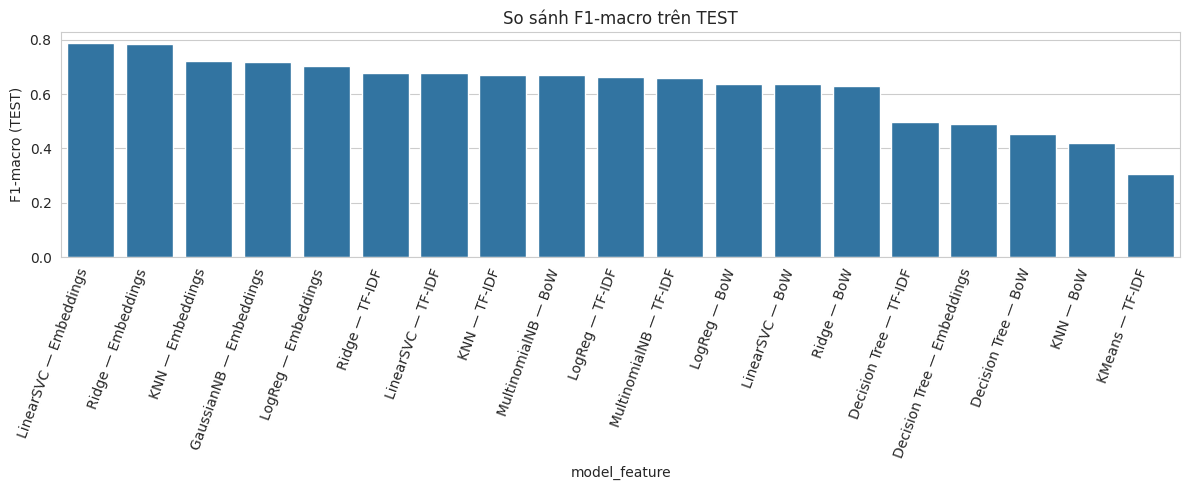

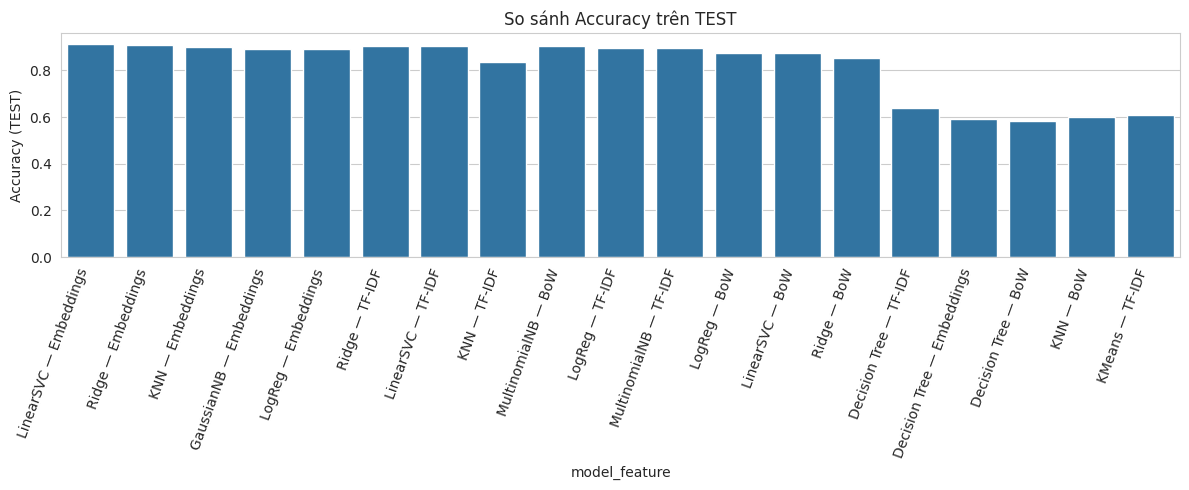

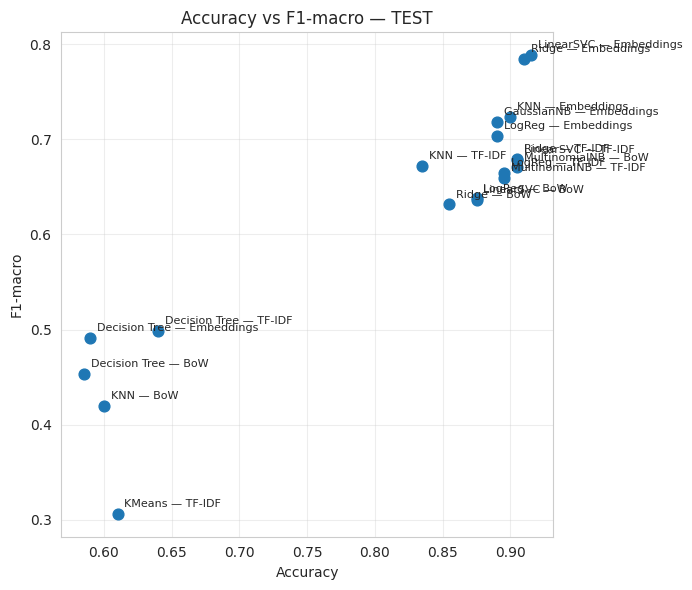

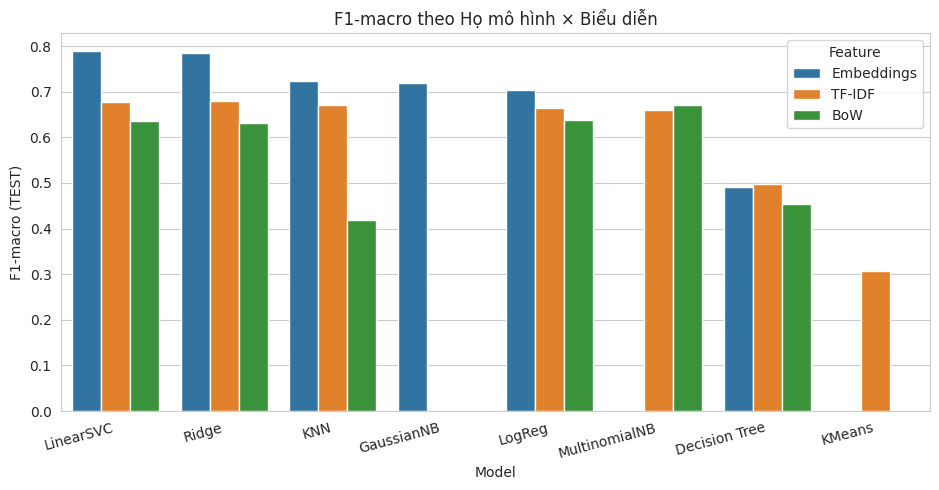

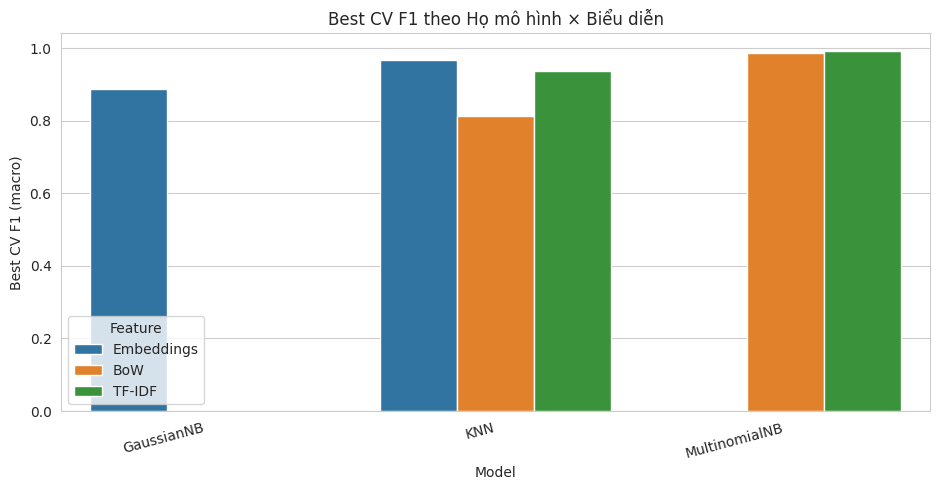

💾 Saved:
 - cv_best_summary.csv
 - test_metrics_all_models.csv
 - Figures/Confusion Matrices → pdf/Figures/all_models


In [29]:
DO_PLOT = True          # đặt False nếu muốn bỏ phần vẽ cho nhanh
INCLUDE_KMEANS = True   # thêm hàng KMeans vào bảng CV

# --- 1) BẢNG TÓM TẮT CV ---
summary_cv = (
    pd.DataFrame(summary_rows)
      .sort_values(["Model", "Feature"])
      .reset_index(drop=True)
)

if INCLUDE_KMEANS and ('best_k_kmeans' in globals()) and ('sil_scores' in globals()):
    kmeans_sil_best = float(np.max(sil_scores)) if len(sil_scores) else np.nan
    kmeans_row = pd.DataFrame([{
        "Model": "KMeans",
        "Feature": "TF-IDF",
        "BestParam": f"k={int(best_k_kmeans)}",
        "BestCV_F1": np.nan,
        "Silhouette": kmeans_sil_best
    }])
    if "Silhouette" not in summary_cv.columns:
        summary_cv["Silhouette"] = np.nan
    summary_cv = pd.concat([summary_cv, kmeans_row], ignore_index=True)

print("🔎 BẢNG TÓM TẮT CV:")
display(summary_cv)

# --- 2) TỔNG HỢP TEST ---
if 'results_test' not in globals():
    test_rows = []
    pred_map = {
        "KMeans — TF-IDF":               kmeans_pred,
        "KNN — BoW":                     knn_bow_pred,
        "KNN — TF-IDF":                  knn_tfidf_pred,
        "KNN — Embeddings":              knn_emb_pred,
        "Decision Tree — BoW":           dt_bow_pred,
        "Decision Tree — TF-IDF":        dt_tfidf_pred,
        "Decision Tree — Embeddings":    dt_emb_pred,
        "MultinomialNB — BoW":           mnb_bow_pred,
        "MultinomialNB — TF-IDF":        mnb_tfidf_pred,
        "GaussianNB — Embeddings":       gnb_emb_pred,
        "Ridge — BoW":                   ridge_bow_pred,
        "Ridge — TF-IDF":                ridge_tfidf_pred,
        "Ridge — Embeddings":            ridge_emb_pred,
        "LogReg — BoW":                  log_bow_pred,
        "LogReg — TF-IDF":               log_tfidf_pred,
        "LogReg — Embeddings":           log_emb_pred,
        "LinearSVC — BoW":               svc_bow_pred,
        "LinearSVC — TF-IDF":            svc_tfidf_pred,
        "LinearSVC — Embeddings":        svc_emb_pred,
    }
    for name, yhat in pred_map.items():
        test_rows.append(summarize_result(name, y_test, yhat))
    results_test = (
        pd.DataFrame(test_rows)
          .sort_values(["f1_macro", "accuracy"], ascending=False)
          .reset_index(drop=True)
    )

print("\n🏁 TỔNG HỢP KẾT QUẢ TEST (Top 10):")
display(results_test.head(10))

best_row = results_test.iloc[0]
print(f"🏆 Best TEST: {best_row['model_feature']} | "
      f"Acc={best_row['accuracy']:.4f} | F1-macro={best_row['f1_macro']:.4f}")

# --- 3) HÀM VẼ CHUNG ---
sns.set_style("whitegrid")

def plot_test_overview(results_test, save_dir=PATHS.root):
    plt.figure(figsize=(12, 5))
    sns.barplot(data=results_test, x="model_feature", y="f1_macro")
    plt.xticks(rotation=70, ha="right"); plt.ylabel("F1-macro (TEST)")
    plt.title("So sánh F1-macro trên TEST")
    plt.tight_layout(); plt.savefig(os.path.join(save_dir, "test_f1macro.pdf")); plt.show()

    plt.figure(figsize=(12, 5))
    sns.barplot(data=results_test, x="model_feature", y="accuracy")
    plt.xticks(rotation=70, ha="right"); plt.ylabel("Accuracy (TEST)")
    plt.title("So sánh Accuracy trên TEST")
    plt.tight_layout(); plt.savefig(os.path.join(save_dir, "test_accuracy.pdf")); plt.show()

def plot_test_scatter(results_test, save_dir=PATHS.root):
    plt.figure(figsize=(7, 6))
    plt.scatter(results_test["accuracy"], results_test["f1_macro"], s=60)
    for _, r in results_test.iterrows():
        plt.annotate(r["model_feature"], (r["accuracy"], r["f1_macro"]),
                     fontsize=8, xytext=(5,5), textcoords="offset points")
    plt.xlabel("Accuracy"); plt.ylabel("F1-macro")
    plt.title("Accuracy vs F1-macro — TEST")
    plt.grid(True, alpha=.35); plt.tight_layout()
    plt.savefig(os.path.join(save_dir, "test_scatter.pdf")); plt.show()

def plot_family_feature_bars(results_test, summary_cv, save_dir=PATHS.root):
    df_test = results_test.copy()
    mf = df_test["model_feature"].str.split("—").apply(lambda x: (x[0].strip(), x[1].strip()))
    df_test["Model"], df_test["Feature"] = zip(*mf)

    plt.figure(figsize=(9.5, 5))
    sns.barplot(data=df_test, x="Model", y="f1_macro", hue="Feature")
    plt.ylabel("F1-macro (TEST)")
    plt.title("F1-macro theo Họ mô hình × Biểu diễn")
    plt.xticks(rotation=15, ha="right"); plt.tight_layout()
    plt.savefig(os.path.join(save_dir, "families_features_test.pdf")); plt.show()

    if summary_cv is not None and not summary_cv.empty:
        plt.figure(figsize=(9.5, 5))
        sns.barplot(data=summary_cv.dropna(subset=["BestCV_F1"]), x="Model", y="BestCV_F1", hue="Feature")
        plt.ylabel("Best CV F1 (macro)")
        plt.title("Best CV F1 theo Họ mô hình × Biểu diễn")
        plt.xticks(rotation=15, ha="right"); plt.tight_layout()
        plt.savefig(os.path.join(save_dir, "families_features_cv.pdf")); plt.show()

# --- 4) GỌI HÀM VẼ ---
if DO_PLOT:
    plot_test_overview(results_test)
    plot_test_scatter(results_test)
    plot_family_feature_bars(results_test, summary_cv)

# --- 5) LƯU CSV ---
summary_cv.to_csv("cv_best_summary.csv", index=False)
results_test.to_csv("test_metrics_all_models.csv", index=False)

print("💾 Saved:")
print(" - cv_best_summary.csv")
print(" - test_metrics_all_models.csv")
print(f" - Figures/Confusion Matrices → {PATHS.all_models}")


#**Streamlit**

In [53]:
!pip install -q streamlit cloudflared plotly seaborn sentence-transformers scikit-learn joblib
!streamlit run app.py --server.port 8501 --server.headless true &> /content/streamlit.log &
!wget -q -O /usr/local/bin/cloudflared https://github.com/cloudflare/cloudflared/releases/latest/download/cloudflared-linux-amd64
!chmod +x /usr/local/bin/cloudflared
!/usr/local/bin/cloudflared tunnel --url http://localhost:8501 --no-autoupdate > /content/cf.log 2>&1 &
import time, re, os; time.sleep(5)
log=open('/content/cf.log').read() if os.path.exists('/content/cf.log') else ''
m=re.search(r'https://[-0-9a-z]+\.trycloudflare\.com', log)
print('🔗', m.group(0) if m else 'Không thấy URL, mở /content/cf.log kiểm tra')


/usr/local/bin/cloudflared: Text file busy
🔗 https://healthy-campaign-mirrors-eval.trycloudflare.com


2025-09-01 19:48:29.116 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-01 19:48:29.130 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2025-09-01 19:48:29.135 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2025-09-01 19:48:29.141 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2025-09-01 19:48:29.146 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2025-09-01 19:48:29.151 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-01 19:48:30.949 
  command:

    streamlit run /usr/local/lib/python3.12/dist-packages/colab_kernel_launcher.py [A

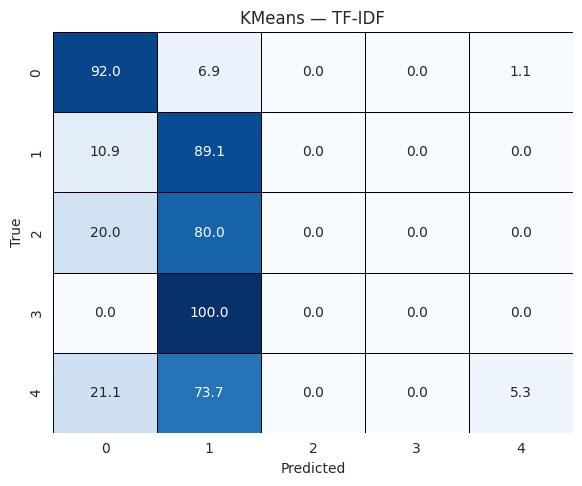

In [52]:
# app.py — NLP Leaderboard & Inference (robust)
import os, json, joblib, numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import streamlit as st
from sentence_transformers import SentenceTransformer
from sklearn.metrics import confusion_matrix, f1_score

# ================== PAGE CONFIG & STYLE ==================
st.set_page_config(page_title="Model Leaderboard", layout="wide")
sns.set_style("whitegrid")

# ================== HELPERS (LOAD/CACHE) ==================
@st.cache_data
def load_csv_with_fallback(primary="results_summary.csv", fallback="test_metrics_all_models.csv"):
    """Ưu tiên đọc primary; nếu không có thì thử fallback; nếu không cái nào có -> None."""
    path = primary if os.path.exists(primary) else (fallback if os.path.exists(fallback) else None)
    if path is None:
        return None, None
    try:
        df = pd.read_csv(path)
        return df, path
    except Exception as e:
        st.error(f"Không đọc được CSV '{path}': {e}")
        return None, None

@st.cache_data
def load_json_file(path):
    if not os.path.exists(path):
        return None
    with open(path, "r", encoding="utf-8") as f:
        return json.load(f)

@st.cache_data
def load_numpy_file(path):
    if not os.path.exists(path):
        return None
    return np.load(path)

@st.cache_resource
def load_joblib_file(path):
    if not os.path.exists(path):
        return None
    return joblib.load(path)

@st.cache_resource
def get_sentence_model(name: str):
    return SentenceTransformer(name)

def ensure_model_feature_column(df: pd.DataFrame) -> pd.DataFrame:
    """Đảm bảo có cột model_feature (nếu file là test_metrics_all_models.csv)."""
    if "model_feature" in df.columns:
        return df
    # thử suy đoán từ các tên cột thường gặp
    candidates = ["ModelFeature","Model_Feature","Model — Feature","Model - Feature","model","Model"]
    for c in candidates:
        if c in df.columns:
            df = df.rename(columns={c: "model_feature"})
            return df
    # hoặc nếu có "Model" + "Feature"
    if {"Model","Feature"}.issubset(df.columns):
        df["model_feature"] = df["Model"].astype(str) + " — " + df["Feature"].astype(str)
    return df

# ================== LOAD ARTEFACTS ==================
results_df, results_src = load_csv_with_fallback("results_summary.csv", "test_metrics_all_models.csv")
meta          = load_json_file("best_meta.json") or {}
id_to_label   = load_json_file("id_to_label.json") or {}
sorted_labels = load_json_file("sorted_labels.json") or []
preds_map     = load_json_file("preds.json") or {}
y_test_arr    = load_numpy_file("y_test.npy")

# Chuẩn hoá id_to_label key -> int
try:
    id_to_label = {int(k): v for k, v in id_to_label.items()}
except Exception:
    pass

# Chuẩn hoá results_df
if results_df is not None:
    results_df = ensure_model_feature_column(results_df)

# ================== SIDEBAR ==================
with st.sidebar:
    st.markdown("### ⚙️ Artefacts")
    st.write("- **Results**:", "✅" if results_df is not None else "❌",
             results_src if results_src else "(missing)")
    st.write("- **preds.json**:", "✅" if preds_map else "❌")
    st.write("- **y_test.npy**:", "✅" if (isinstance(y_test_arr, np.ndarray) and y_test_arr.size) else "❌")
    st.write("- **id_to_label.json**:", "✅" if id_to_label else "❌")
    st.write("- **sorted_labels.json**:", "✅" if sorted_labels else "❌")
    st.write("- **best_model.joblib**:", "✅" if os.path.exists("best_model.joblib") else "❌")
    st.write("- **bow_vectorizer.joblib**:", "✅" if os.path.exists("bow_vectorizer.joblib") else "❌")
    st.write("- **tfidf_vectorizer.joblib**:", "✅" if os.path.exists("tfidf_vectorizer.joblib") else "❌")

    st.divider()
    st.caption("Nếu thiếu file, hãy quay lại notebook và chạy block export artefacts.")

# ================== GUARD CLAUSES ==================
if results_df is None:
    st.error("Thiếu **results_summary.csv**/**test_metrics_all_models.csv**. Hãy export summary trong notebook.")
    st.stop()

if not preds_map or y_test_arr is None or y_test_arr.size == 0:
    st.warning("Thiếu **preds.json** hoặc **y_test.npy**. Hãy chạy block xuất dự đoán trong notebook trước khi mở app.")
    st.stop()

# ================== HEADER ==================
st.title("📊 NLP Leaderboard & Inference Demo")

# ================== LAYOUT: LEFT (charts/table) — RIGHT (confusion) ==================
left, right = st.columns([1.35, 1])

with left:
    st.subheader("📈 Thống kê")
    tab_f1, tab_acc, tab_table = st.tabs(["F1-macro (higher is better)", "Accuracy", "Leaderboard table"])

    # F1 bar
    with tab_f1:
        if "model_feature" in results_df.columns and "f1_macro" in results_df.columns:
            fig1 = px.bar(results_df, x="model_feature", y="f1_macro",
                          hover_data=[c for c in ["accuracy","f1_weighted"] if c in results_df.columns])
            fig1.update_layout(xaxis_tickangle=-45, margin=dict(l=10, r=10, t=30, b=10), height=420)
            st.plotly_chart(fig1, use_container_width=True)
        else:
            st.info("File kết quả không có cột 'f1_macro'.")

    # Acc bar
    with tab_acc:
        if "accuracy" in results_df.columns and "model_feature" in results_df.columns:
            fig2 = px.bar(results_df, x="model_feature", y="accuracy")
            fig2.update_layout(xaxis_tickangle=-45, margin=dict(l=10, r=10, t=30, b=10), height=420)
            st.plotly_chart(fig2, use_container_width=True)
        else:
            st.info("File kết quả không có cột 'accuracy'.")

    # Table
    with tab_table:
        df_disp = results_df.copy()
        fmt_cols = {c: "{:.4f}" for c in ["accuracy", "f1_macro", "f1_weighted"] if c in df_disp.columns}
        st.dataframe(df_disp.style.format(fmt_cols), use_container_width=True, height=420)

with right:
    st.subheader("📌 Chọn mô hình & xem Confusion Matrix")
    model_list = list(preds_map.keys())
    if not model_list:
        st.error("preds.json không chứa mô hình nào.")
        st.stop()

    model_opt = st.selectbox("Mô hình", model_list, index=0)
    normalize = st.checkbox("Chuẩn hóa theo hàng (%)", value=True)

    y_pred_app = np.array(preds_map[model_opt], dtype=int)
    labels_idx = list(range(len(sorted_labels))) if sorted_labels else sorted(list(set(y_test_arr)))
    cm = confusion_matrix(y_test_arr, y_pred_app, labels=labels_idx)

    if normalize:
        row_sums = cm.sum(axis=1, keepdims=True).clip(min=1)
        cm_view = (cm / row_sums) * 100.0
        fmt = ".1f"
    else:
        cm_view = cm
        fmt = "d"

    # Draw heatmap
    fig, ax = plt.subplots(figsize=(6.7, 5.2))
    sns.heatmap(
        cm_view, annot=True, fmt=fmt, cmap="Blues",
        xticklabels=(sorted_labels if sorted_labels else labels_idx),
        yticklabels=(sorted_labels if sorted_labels else labels_idx),
        cbar=False, linewidths=.5, linecolor="black", ax=ax
    )
    ax.set_xlabel("Predicted"); ax.set_ylabel("True"); ax.set_title(model_opt)
    st.pyplot(fig, use_container_width=True)

# ================== PER-CLASS F1 (TOP-K) ==================
st.subheader("🔎 Per-class F1 cho Top-K mô hình (TEST)")
top_k = st.slider("Chọn K", min_value=1, max_value=min(10, len(results_df)), value=min(5, len(results_df)))
top_rows = results_df.head(top_k).copy() if "model_feature" in results_df.columns else pd.DataFrame()

if top_rows.empty:
    st.info("Không thể hiển thị Top-K do thiếu cột 'model_feature'.")
else:
    cols = st.columns(len(top_rows))
    class_names = (sorted_labels if sorted_labels else [str(i) for i in sorted(list(set(y_test_arr)))])
    for i, (_, row) in enumerate(top_rows.iterrows()):
        name = row["model_feature"]
        if name not in preds_map:
            continue
        y_hat = np.array(preds_map[name], dtype=int)
        f1s = f1_score(y_test_arr, y_hat, average=None, labels=np.arange(len(class_names)))

        with cols[i]:
            st.markdown(f"**{name}**")
            fig = px.bar(x=class_names, y=f1s, labels={"x": "Class", "y": "F1"})
            fig.update_layout(xaxis_tickangle=-35, height=320, yaxis_range=[0, 1.0],
                              margin=dict(l=10, r=10, t=30, b=10))
            st.plotly_chart(fig, use_container_width=True)

# ================== INFERENCE ==================
st.subheader("🔮 Đề xuất mô hình tốt nhất & thử dự đoán")
if meta:
    st.info(f"Đề xuất: **{meta.get('model_feature','N/A')}**  |  Feature: `{meta.get('feature','N/A')}`")
else:
    st.warning("Chưa có best_meta.json — vẫn có thể dự đoán nếu tải thủ công best_model.joblib & vectorizer.")

text = st.text_area("Nhập abstract/đoạn văn bản cần phân loại", height=160, placeholder="Paste your text here...")
run = st.button("Dự đoán")

def encode_texts(texts, feature: str, emb_model_name: str):
    feat = (feature or "").lower()
    if feat == "bow":
        vec = load_joblib_file("bow_vectorizer.joblib")
        if vec is None:
            st.error("Thiếu bow_vectorizer.joblib — không thể suy luận với 'bow'.")
            st.stop()
        return vec.transform(texts)

    if feat in ("tf-idf", "tfidf"):
        vec = load_joblib_file("tfidf_vectorizer.joblib")
        if vec is None:
            st.error("Thiếu tfidf_vectorizer.joblib — không thể suy luận với 'tf-idf'.")
            st.stop()
        return vec.transform(texts)

    # embeddings
    emb_name = emb_model_name or "intfloat/multilingual-e5-base"
    s_model = get_sentence_model(emb_name)
    arr = s_model.encode([f"query: {t}" for t in texts], normalize_embeddings=True)
    return np.array(arr)

if run and text.strip():
    model = load_joblib_file("best_model.joblib")
    if model is None:
        st.error("Thiếu best_model.joblib — hãy chạy block train & lưu model trong notebook.")
        st.stop()

    feature = (meta.get("feature") if meta else None) or "embeddings"
    emb_model_name = (meta or {}).get("emb_model", "intfloat/multilingual-e5-base")

    X_inf = encode_texts([text], feature, emb_model_name)
    # GaussianNB cần dense
    if model.__class__.__name__ == "GaussianNB":
        X_inf = X_inf.toarray() if hasattr(X_inf, "toarray") else X_inf

    pred = int(model.predict(X_inf)[0])
    label = id_to_label.get(pred, str(pred))
    st.success(f"Kết quả: **{label}**")
